# Read in the data

In [19]:
import pandas
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [20]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [21]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [22]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [23]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [24]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [25]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [26]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [27]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Find Correlations Between SAT Scores and Survey Responses

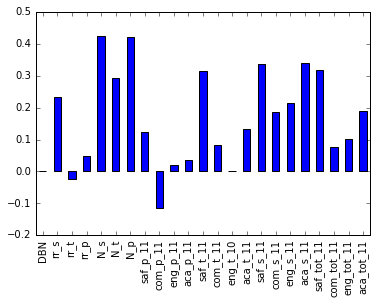

In [29]:
# Filter correlations on the fields in survey_fields and plot the remaining correlations in a bar chart
correlations.loc[survey_fields].plot(kind="bar")

plt.show()

Let's filter these correlations to keep only those >0.25

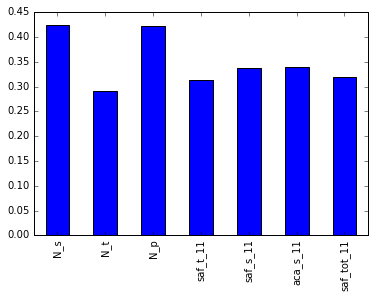

In [51]:
# Filter correlations on the fields in survey_fields and keep only those >= 0.25
survey_correlations = correlations.loc[survey_fields]
survey_correlations = survey_correlations[abs(survey_correlations) >= 0.25]
survey_correlations.plot(kind="bar")

The most significant correlations are the number of student, teacher and parent respondents, along with the perceived safety of the school (by teachers and students) and the academic expectations score for students.

The number of respondents is related to our discussion of the total enrollment attribute above, and serves as a proxy for the percentage of English learners.

The other correlated fields should be explored further but preliminary hypotheses could be as follow:
* Where perceived safety is higher, students can focus on their studies and teachers on their teaching more than in schools where perceived safety is lower;
* Students with high academic expectations scores could be high-performing students in the first place, which would explain their high SAT scores.

# Safety And SAT Scores

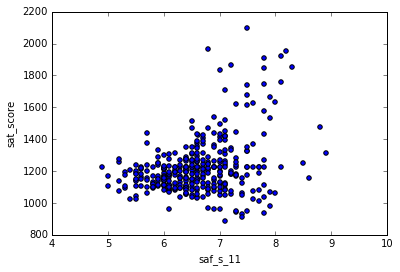

In [55]:
combined.plot.scatter("saf_s_11", "sat_score")
plt.show()

There seems to be a linear correlation between safety perception among students and SAT scores.

In [58]:
# MAP SAFETY PERCEPTION USING BASEMAP, CAN'T BE DONE USING DATAQUEST'S IMAGE

# Race And SAT Scores

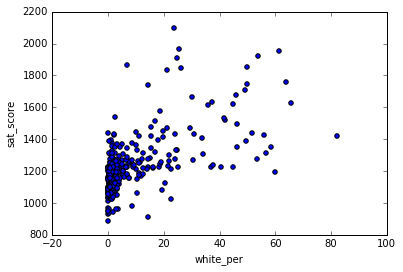

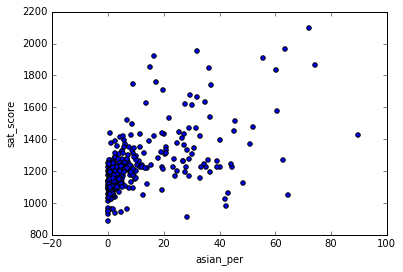

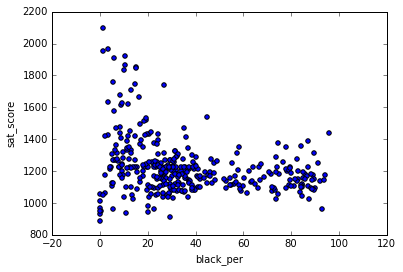

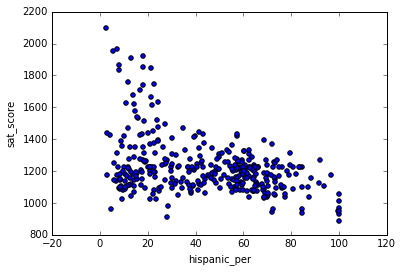

In [63]:
# List of columns related to race percentages
race_columns = ["white_per", "asian_per", "black_per", "hispanic_per"]

# Plot the correlations between race percentages and SAT score
for col in race_columns:
    combined.plot.scatter(col, "sat_score")

There's a positive correlation between SAT scores and the percentage of white and asian students; this correlation is negative for black and hispanic students.

In [71]:
# Filter the schools to keep only those with a hispanic_per > 95%
high_hispanic_per = combined[combined["hispanic_per"]>95]
# Print the names of the schools
print(high_hispanic_per["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


After researching these schools on the web, it seems that they are focused on immigrants from Spanish-speaking countries. We can relate this to our discussion of the relationship between SAT scores and the percentage of English learners.

In [74]:
# Filter the schools: hispanic_per < 10% and sat_score > 1800
low_hisp_high_sat = combined[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800)]
# Print the names of the schools
print(low_hisp_high_sat["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


All these high schools are very selective, technical schools.

# Gender And SAT Scores

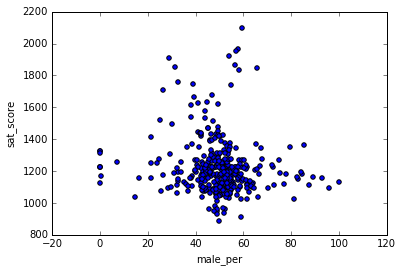

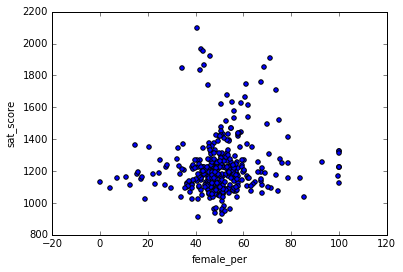

In [78]:
gender_cols = ["male_per","female_per"]
# Make a scatterplot of male_per and female_per versus sat_score
for col in gender_cols:
    combined.plot.scatter(col,"sat_score")
plt.show()

Despite the r-scores computed above, which indicated a positive correlation between the percentage of females and SAT scores, and a negative correlation between the percentage of males and SAT scores, the scatter plots above show that there doesn't seem to be a linear correlation.

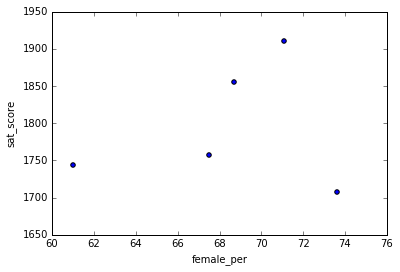

In [85]:
# Filter for high female_per and high sat_score
high_fem_high_sat = combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]
# Scatterplot of these schools
high_fem_high_sat.plot.scatter("female_per","sat_score")
plt.show()

In [86]:
print(high_fem_high_sat["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools also appear to be very selective.

# AP Scores And SAT Scores

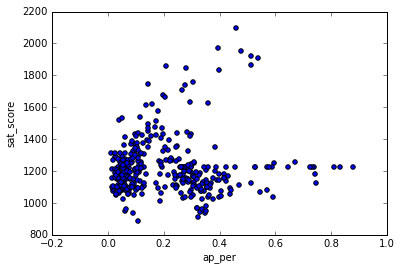

In [91]:
# Computer the percentage of students in each school who took the AP exam
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
# Scatterplot of ap_per and sat_score
combined.plot.scatter("ap_per","sat_score")
plt.show()

The overall correlation seems to be linear and positive. However, a particular pattern stands out: from a cluster of low AP Percentage and low SAT Scores, the data stretches out along to axes; one with a clear positive correlation; the other with no correlation.

# Next Steps
* Looking at class size and SAT scores.
* Figuring out the best area to live in based on school performance.
    * If we combine this with a property values dataset, we could find the cheapest place where there are good school.
* Looking into the differences between parent, teacher, and student responses to surveys.
* Assigning a score to schools based on sat_score and other attributes.
